In [1]:


import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


<center>
<span style="font-family:luxury; color:Black; font-size:45px;"> FAKE NEWS CLASSIFIER </span>
</center>   
<center>
<span style="font-family:luxury; color:Black	; font-size:30px;"> LSTM Model</span>
</center> 
<center>
<span style="font-family:luxury; color:Black	; font-size:20px;"> Yelemessov Alinur and Nuran Zhangazy</span>
</center> 

<span style="font-family:luxury; color:Black; font-size:30px;"> Reading train data</span>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
train= pd.read_csv("/kaggle/input/fake-news/train.csv")
print("data shape :", train.shape)
train.head()

data shape : (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<span style="font-family:luxury; color:Black; font-size:30px;"> Reading test data</span>

In [4]:
test= pd.read_csv("/kaggle/input/fake-news/test.csv")
print("data shape :", test.shape)
test.head()

data shape : (5200, 4)


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


<span style="font-family:luxury; color:Black; font-size:30px;"> Combined data</span><br>
<span style="color:Black; font-size:15px;">
    Concating both train and test dataset so that text preprocessing before giving it to model can be done simultaneously on both of them.
</span>

In [5]:
# creating an additional column to distinguish between the datasets after concating
train["train/test"]= "train"
test["train/test"]= "test"

# concating
combined_data= pd.concat([train, test], axis=0)
print("combined data shape :", combined_data.shape)
combined_data.head()

combined data shape : (26000, 6)


,id,title,author,text,label,train/test
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,train
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,train
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,train
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,train
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,train


<span style="font-family:luxury; color:Black; font-size:30px;"> Data Preprocessing</span><br>

<span style="color:Black; font-size:15px;">
    The "text" column is the column which contains the news, so we only need to preprocess this, we'll also take "train/test"
column so that both the datasets can be distinguished later
</span>

In [6]:
combined_data= combined_data.drop(columns=["id","author" , "title", "label"], axis=1)
combined_data.head()

,text,train/test
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train
1,Ever get the feeling your life circles the rou...,train
2,"Why the Truth Might Get You Fired October 29, ...",train
3,Videos 15 Civilians Killed In Single US Airstr...,train
4,Print \nAn Iranian woman has been sentenced to...,train


<span style="font-family:luxury; color:Black; font-size:25px;"> Check Missing Values</span><br>

In [7]:
combined_data.isnull().sum()

text          46
train/test     0
dtype: int64

In [8]:
# replace missing values
combined_data= combined_data.fillna(" ")

<span style="color:Black; font-size:15px;">
The first step in data preprocessing is to consider only alphabets and removing the numbers, special characters and converting all the words to lower case
</span>

In [9]:
import re
def clean(text):
    # removing all the characters other than alphabets
    cleaned_text= re.sub("[^a-zA-Z]", " ", text)
    # converting text to lower case
    cleaned_text= cleaned_text.lower()
    return cleaned_text

# Now creating a separate column which contains the above function applied to "text" column
combined_data["cleaned(only alphabets)"]= combined_data["text"].apply(lambda x : clean(x) )
combined_data.head()

,text,train/test,cleaned(only alphabets)
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...


<span style="color:Black; font-size:15px;">
 Second step is to convert the whole text into a list of words, so that the stop words can be applied to them later
</span>

In [10]:
def text_to_words(text):
    words= text.split()
    return words

# column containing text converted to list of words
combined_data["text_to_words"]= combined_data["cleaned(only alphabets)"].apply(lambda x : text_to_words(x))
combined_data.head()

,text,train/test,cleaned(only alphabets),text_to_words
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com..."
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,..."
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo..."
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai..."
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc..."


<span style="color:Black; font-size:15px;">
 Words like a, the , is , then etc are redundant and doesn't play any role in nlp, so it's better to remove these type of words. And stop words is the way to do that.
</span>

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def clean_words(word_list):
    # applying stop words
    word= [stemmer.stem(word) for word in word_list if not word in stopwords.words("english")]
    # joining them again
    word= " ".join(word)
    return word  

combined_data["cleaned_words"]= combined_data["text_to_words"].apply(lambda x: clean_words(x))

In [12]:
combined_data.head(7)

,text,train/test,cleaned(only alphabets),text_to_words,cleaned_words
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com...",hous dem aid even see comey letter jason chaff...
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,...",ever get feel life circl roundabout rather hea...
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo...",truth might get fire octob tension intellig an...
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai...",video civilian kill singl us airstrik identifi...
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenc six year prison ir...
5,"In these trying times, Jackie Mason is the Voi...",train,in these trying times jackie mason is the voi...,"[in, these, trying, times, jackie, mason, is, ...",tri time jacki mason voic reason week exclus c...
6,Ever wonder how Britain’s most iconic pop pian...,train,ever wonder how britain s most iconic pop pian...,"[ever, wonder, how, britain, s, most, iconic, ...",ever wonder britain icon pop pianist get long ...


<span style="color:Black; font-size:15px;">
So we got our cleaned_words, create a function to count number of words it contains
</span>

In [13]:
def word_count(text):
    text = str(text)
    return len(text.split(' '))

combined_data['word_count'] = combined_data['cleaned_words'].apply(word_count)
combined_data.head()

,text,train/test,cleaned(only alphabets),text_to_words,cleaned_words,word_count
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com...",hous dem aid even see comey letter jason chaff...,433
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,...",ever get feel life circl roundabout rather hea...,367
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo...",truth might get fire octob tension intellig an...,692
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai...",video civilian kill singl us airstrik identifi...,305
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenc six year prison ir...,86


<span style="color:Black; font-size:15px;">
Let's have a look at what we have done till now. Let's compare the text before and after preprocessing 
</span>

In [14]:
print("Text Before Preprocessing :\n\n", combined_data["text"][0])
print("\n\nText After Preprocessing :\n\n",combined_data["cleaned_words"][0])

Text Before Preprocessing :

 0    House Dem Aide: We Didn’t Even See Comey’s Let...
0    PALO ALTO, Calif.  —   After years of scorning...
Name: text, dtype: object


Text After Preprocessing :

 0    hous dem aid even see comey letter jason chaff...
0    palo alto calif year scorn polit process silic...
Name: cleaned_words, dtype: object


<span style="font-family:luxury; color:Black; font-size:30px;"> Separating train and test dataset</span><br>

In [15]:
train_data= combined_data[combined_data["train/test"] == "train"]
test_data= combined_data[combined_data["train/test"] == "test"]

<span style="font-family:luxury; color:Black; font-size:25px;"> Vector Representation of words</span><br>
<span style="color:Black; font-size:15px;">
Now we have to convert meaningful text into vector representation such that a machine can understand the pattern associated in any text and can make out the context of sentences.<br>
And for this we will be using word embedding technique.    
</span>

<span style="font-family:luxury; color:BlaCk; font-size:25px;"> One-hot Encoding</span><br>
<span style="color:Black; font-size:15px;">
Before applying word embedding, words must be one-hot encoded
</span>

In [16]:
from keras.preprocessing.text import one_hot
vocab_size= 10000

# one-hot encoding train_data
trainWords_to_list= []
for i in range(0, len(train_data)):
    trainWords_to_list.append(train_data["cleaned_words"][i])
    
encoded_train= [one_hot(word, vocab_size) for word in trainWords_to_list]


# one-hot encoding test_data
testWords_to_list= []
for i in range(0, len(test_data)):
    testWords_to_list.append(test_data["cleaned_words"][i])
    
encoded_test= [one_hot(word, vocab_size) for word in testWords_to_list]

<span style="color:Black; font-size:15px;">
This is how one-hot encoded text looks like. Each word is represented by it's index number present in the vocabulary size.
</span>

In [17]:
encoded_train[0]

[3663,
 9229,
 4159,
 5514,
 4410,
 6331,
 2204,
 1599,
 2306,
 5074,
 6392,
 2411,
 1181,
 2579,
 1599,
 2306,
 4758,
 1501,
 4053,
 2288,
 7836,
 6989,
 1573,
 1258,
 2950,
 7988,
 9435,
 9801,
 4517,
 8392,
 695,
 4192,
 6645,
 7454,
 8403,
 8160,
 1608,
 5783,
 9951,
 6331,
 2265,
 3663,
 2709,
 4159,
 7121,
 2846,
 862,
 5079,
 2873,
 6645,
 7454,
 988,
 5406,
 6331,
 9250,
 3690,
 2204,
 7709,
 1608,
 7121,
 7157,
 2161,
 4195,
 8036,
 7900,
 7157,
 5982,
 2689,
 2709,
 297,
 6844,
 8894,
 6331,
 8107,
 4852,
 5074,
 41,
 479,
 6844,
 610,
 5079,
 6331,
 685,
 479,
 610,
 2709,
 2689,
 2648,
 3663,
 9490,
 8972,
 4344,
 6844,
 4499,
 136,
 7157,
 5660,
 3253,
 9425,
 4410,
 244,
 2362,
 9564,
 5654,
 2204,
 6297,
 4344,
 6844,
 5770,
 1599,
 2306,
 8436,
 440,
 8403,
 8877,
 5074,
 1608,
 5189,
 9564,
 1608,
 7996,
 9642,
 7157,
 8649,
 5683,
 9840,
 6868,
 4502,
 1599,
 2306,
 6117,
 1181,
 8877,
 5079,
 6868,
 6331,
 5690,
 3657,
 136,
 7157,
 5913,
 323,
 6868,
 5079,
 277,
 6

<span style="font-family:luxury; color:Black; font-size:25px;"> Text Padding</span><br>
<span style="color:Black; font-size:15px;">
Model require to have inputs with the same shape and size. And not all the sentences have the same length. So we need to do padding.<br>
    Padding is done by adding zeros for short sentences(pre or post the sentence) and truncating the sentences which exceed the max number of words which is declared by "maxlen".
</span>

In [18]:
from keras.preprocessing.sequence import pad_sequences
text_length= 500

# applying padding to one-hot encoded train_data
padded_train= pad_sequences(encoded_train, padding= "pre", maxlen=text_length)

# applying padding to one-hot encoded test_data
padded_test= pad_sequences(encoded_test, padding= "pre", maxlen=text_length)

<span style="color:Black; font-size:15px;">
It can be seen that in the first text of train_data, zeros have been added to make it equal to text_length=500
</span>

In [19]:
padded_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 3663, 9229, 4159, 5514, 4410, 6331, 2204, 1599, 2306, 5074,
       6392, 2411, 1181, 2579, 1599, 2306, 4758, 1501, 4053, 2288, 7836,
       6989, 1573, 1258, 2950, 7988, 9435, 9801, 4517, 8392,  695, 4192,
       6645, 7454, 8403, 8160, 1608, 5783, 9951, 6331, 2265, 3663, 2709,
       4159, 7121, 2846,  862, 5079, 2873, 6645, 7454,  988, 5406, 6331,
       9250, 3690, 2204, 7709, 1608, 7121, 7157, 2161, 4195, 8036, 7900,
       7157, 5982, 2689, 2709,  297, 6844, 8894, 6331, 8107, 4852, 5074,
         41,  479, 6844,  610, 5079, 6331,  685,  4

<span style="color:Olive; font-size:15px;">
But in test_data, we cannot see any zeros. This is because the length of this text is already greater than mentioned text_length= 500. So instead it's length have been truncated to make it equal 500.
</span>

In [20]:
padded_test[0]

array([5681, 8568, 4941, 3362,  167, 1168, 7385, 5028,  440, 3810, 2712,
       1689, 4916, 5821, 4039, 2325, 3373, 9954,  440, 5847, 6844, 2556,
       1157, 4663,  988,  757,  782, 3810, 2712, 3988, 1657, 2519, 3657,
       2739, 7768, 2325, 4738, 7881, 3810,  963, 6094,  501,   87, 9764,
       5010, 8709, 4456, 6861, 3810,  963, 8053, 3657,  767, 1720, 3810,
       2712, 5950, 7768, 6842, 2601, 4966, 6862, 2161, 9372, 8036, 4726,
       1017, 1415, 5660, 4039, 6289, 2904, 4966, 1572, 3810, 2712, 8864,
       6765, 7157, 7121, 1444, 2709, 5083, 1157, 8237, 9598, 5514, 3373,
       9954, 6380, 2325, 4966, 6862, 1979, 4551, 7890,  494, 5879, 2290,
       9709,  494, 6989, 5684, 1289, 5880, 4599, 6344, 1508, 3665, 8313,
        610, 3651, 6216, 9372, 2160, 4763, 6868, 7650,  173, 2014, 3810,
       7900, 4852,  396, 2210, 4490, 5684, 2637, 7401, 9050, 2096, 1083,
       6227, 5059, 1021,  440, 7650,  963, 4966, 9153, 2739,  442, 1590,
       5740, 4794, 7768, 2035, 3810, 7900, 3657, 18

<span style="font-family:luxury; color:Black; font-size:30px;">Creating Feature and Target for train_data</span>

In [21]:
import numpy as np
feature= np.array(padded_train)
target= np.array(train["label"])

In [22]:
print("shape of feature", feature.shape)
feature

shape of feature (20800, 500)


array([[   0,    0,    0, ..., 8073, 6781, 3838],
       [   0,    0,    0, ..., 4224, 2347, 7171],
       [1383, 6253, 6695, ..., 9415, 7727, 1288],
       ...,
       [   0,    0,    0, ...,  701, 5026, 7806],
       [   0,    0,    0, ..., 1836, 7667, 1651],
       [2786, 7001, 9492, ..., 7783, 1548, 7768]], dtype=int32)

In [23]:
print("shape of target", target.shape)
target

shape of target (20800,)


array([1, 0, 1, ..., 0, 1, 1])

<span style="color:Black; font-size:15px;">
Since the test data doesn't have "label" column in it, so we need to create a validation data from train_data for training purpose.
</span>

<span style="font-family:luxury; color:Black; font-size:25px;">Splitting train_data into train and validation set</span>

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(feature, target, test_size=0.2, random_state=10)

<span style="font-family:luxury; color:Black; font-size:30px;">Model Building</span>

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM

# number of features is required to be mentioned in order to convert word into it's vector form 
embedding_features= 30

model= Sequential()
# this layer converts padded data into vectors
model.add(Embedding(vocab_size, embedding_features, input_length= text_length))
model.add(Dropout(0.3))

# LSTM layer with 100 neurons
model.add(LSTM(units= 50))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 30)           300000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 30)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 316,251
Trainable params: 316,251
Non-trainable params: 0
_________________________________________________________________


<span style="font-family:luxury; color:Black; font-size:30px;">Model Training</span>

In [26]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history= model.fit(x_train, y_train,
          validation_data= (x_val, y_val),
          batch_size= 100, epochs=10)

Epoch 1/10
167/167 [==============================] - 13s 46ms/step - loss: 0.5358 - accuracy: 0.7370 - val_loss: 0.2224 - val_accuracy: 0.9231
Epoch 2/10
167/167 [==============================] - 7s 41ms/step - loss: 0.1837 - accuracy: 0.9377 - val_loss: 0.1911 - val_accuracy: 0.9303
Epoch 3/10
167/167 [==============================] - 7s 41ms/step - loss: 0.1240 - accuracy: 0.9586 - val_loss: 0.1904 - val_accuracy: 0.9269
Epoch 4/10
167/167 [==============================] - 7s 41ms/step - loss: 0.0987 - accuracy: 0.9699 - val_loss: 0.1837 - val_accuracy: 0.9298
Epoch 5/10
167/167 [==============================] - 7s 40ms/step - loss: 0.0972 - accuracy: 0.9685 - val_loss: 0.1888 - val_accuracy: 0.9337
Epoch 6/10
167/167 [==============================] - 7s 40ms/step - loss: 0.0756 - accuracy: 0.9783 - val_loss: 0.2218 - val_accuracy: 0.9308
Epoch 7/10
167/167 [==============================] - 7s 40ms/step - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.2164 - val_accuracy: 0.926

<span style="font-family:luxury; color:Black; font-size:30px;">Model Evaluation</span>

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

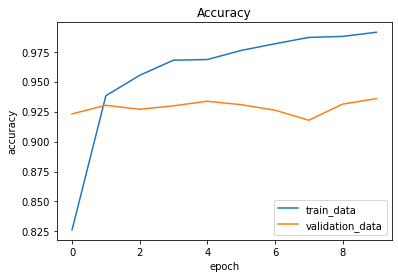

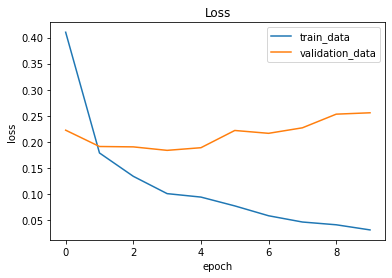

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs= range(len(history.history["accuracy"]))
# accuracy plot
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend(["train_data", "validation_data"])
plt.show()

# loss plot
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend(["train_data", "validation_data"])
plt.show()

<span style="font-family:luxury; color:MediumVioletRed; font-size:20px;">Checking model performance through validation data </span>

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

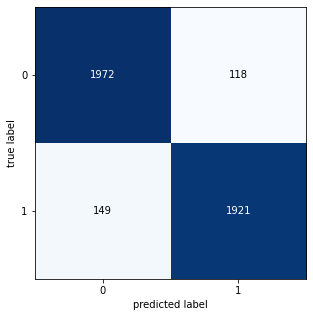

In [29]:
pred_val= model.predict_classes(x_val)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm= confusion_matrix(y_val, pred_val)
plot_confusion_matrix(cm, figsize=(5,5))

<span style="font-family:luxury; color:Black; font-size:30px;">Submission</span>

In [30]:
test_array= np.array(padded_test)
prediction_test= model.predict_classes(test_array)

In [31]:
submission= pd.DataFrame()
submission["id"]= test["id"]
submission["label"]= prediction_test
submission.to_csv("LSTM_model.csv", index=False)
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
